In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import *

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import spearmanr, pearsonr
from scipy.stats import probplot, moment

In [2]:
baltic_data = pd.read_csv('baltics_q.csv', index_col=0, header=0, parse_dates=True)

In [3]:
baltic_data.head()

,EE_GDP,LV_GDP,LT_GDP,EE_HICP,LV_HICP,LT_HICP,EE_Un,LV_Un,LT_Un
Date,,,,,,,,,
1995-01-01,1955.4,2425.5,3574.1,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-01,1936.1,2438.2,3650.1,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-01,1929.5,2412.7,3650.6,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-01,1952.1,2420.7,3725.4,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01,1969.7,2414.2,3773.1,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
baltic_data = baltic_data.loc['2000-01-01':]
baltic_data.isna().sum()

EE_GDP     0
LV_GDP     0
LT_GDP     0
EE_HICP    0
LV_HICP    0
LT_HICP    0
EE_Un      0
LV_Un      0
LT_Un      0
dtype: int64

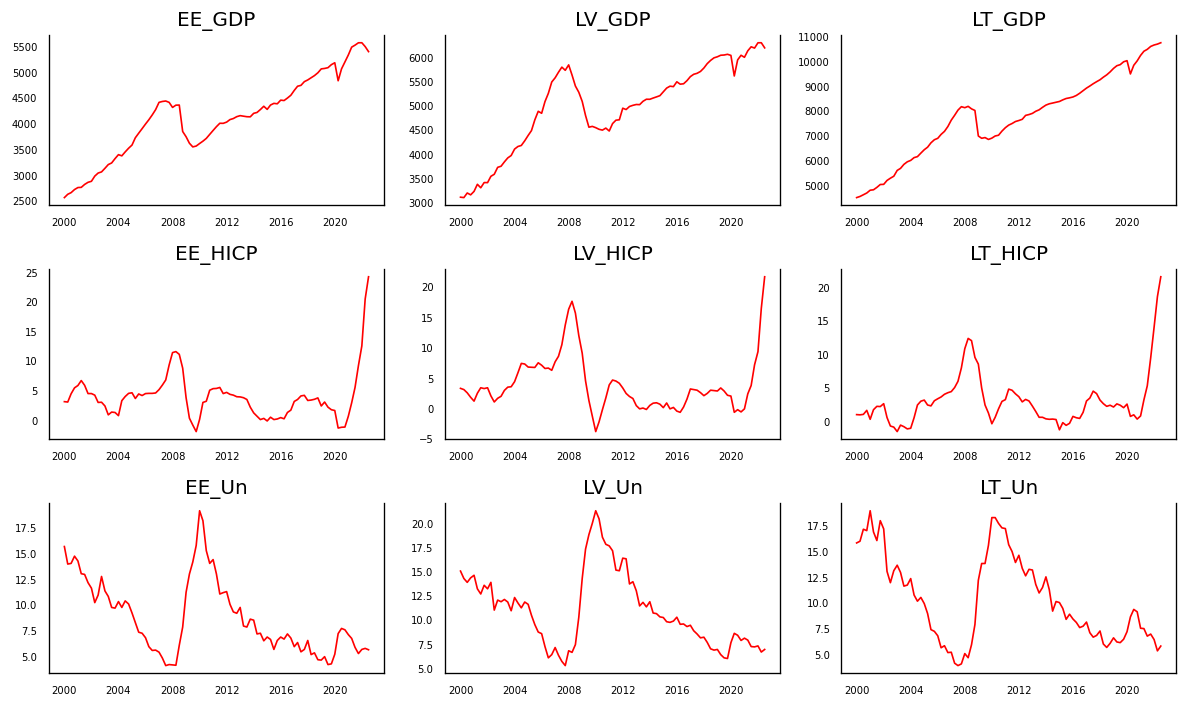

In [5]:
# Visualize the Time Series

fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    data = baltic_data[baltic_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    # Decorations
    ax.set_title(baltic_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    fig.tight_layout()

In [6]:
# Correlation matrix 

baltic_data.corr()

,EE_GDP,LV_GDP,LT_GDP,EE_HICP,LV_HICP,LT_HICP,EE_Un,LV_Un,LT_Un
EE_GDP,1.000000,0.973207,0.988307,0.177115,0.157258,0.402948,-0.751360,-0.641617,-0.740225
LV_GDP,0.973207,1.000000,0.963136,0.168997,0.222438,0.427263,-0.784750,-0.650947,-0.794494
LT_GDP,0.988307,0.963136,1.000000,0.149095,0.107034,0.383964,-0.702805,-0.572987,-0.678912
EE_HICP,0.177115,0.168997,0.149095,1.000000,0.840269,0.900114,-0.205360,-0.264047,-0.244826
LV_HICP,0.157258,0.222438,0.107034,0.840269,1.000000,0.860733,-0.371560,-0.418740,-0.465005
LT_HICP,0.402948,0.427263,0.383964,0.900114,0.860733,1.000000,-0.329458,-0.320554,-0.403108
EE_Un,-0.751360,-0.784750,-0.702805,-0.205360,-0.371560,-0.329458,1.000000,0.929994,0.936987
LV_Un,-0.641617,-0.650947,-0.572987,-0.264047,-0.418740,-0.320554,0.929994,1.000000,0.911641
LT_Un,-0.740225,-0.794494,-0.678912,-0.244826,-0.465005,-0.403108,0.936987,0.911641,1.000000


<AxesSubplot:>

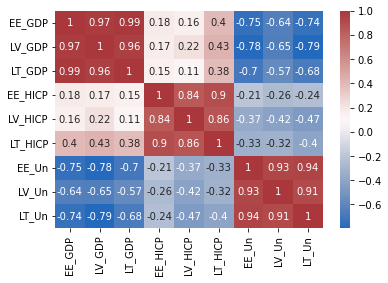

In [7]:
sns.heatmap(baltic_data.corr(), cmap="vlag", annot=True)

In [8]:
# baltic_data[[col for col in baltic_data if col.startswith('EE')]]
baltic_data_ee = baltic_data.filter(regex='^EE',axis=1)
baltic_data_ee.head()

,EE_GDP,EE_HICP,EE_Un
Date,,,
2000-01-01,2554.1,3.033333,15.600000
2000-04-01,2618.1,2.966667,13.900000
2000-07-01,2650.4,4.366667,13.966667
2000-10-01,2710.0,5.366667,14.666667
2001-01-01,2749.1,5.766667,14.200000


In [9]:
def scatter_plot(data, col_1, col_2, color):
    
    """
    Creates scatter plots for inflation, unemployment rate, GDP
    """
    
    fig, ax = plt.subplots(figsize=(7,4))
    
    ax.scatter(x=data[col_1], y=data[col_2], alpha=0.4, color=color)
    ax.set_xlabel("Inflation", fontname="Verdana")
    
    if col_2 == "EE_Un":
        ax.set_title("Inflation and unemployment rate EE", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("Unemployment rate", fontname="Verdana")
    else:
        ax.set_title("Inflation and GDP EE", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("GDP", fontname="Verdana")

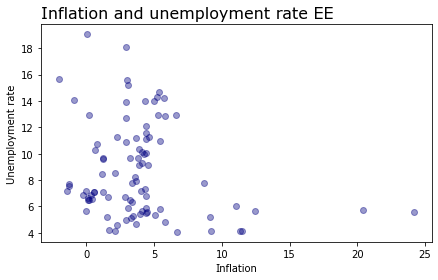

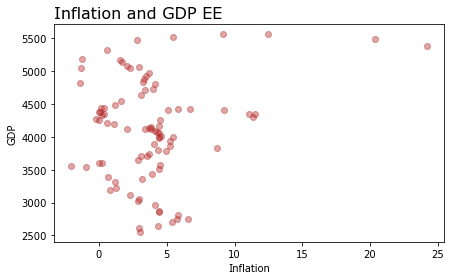

In [10]:
for f,c in dict(zip(["EE_Un", "EE_GDP"], ["navy", "firebrick"])).items():
    scatter_plot(data=baltic_data_ee, col_1="EE_HICP", col_2=f, color=c)

In [11]:
#@title Scatter Plot for different time periods
def scatter_subs(data, col_1, col_2, color):
    
    """
    Break down scatterplots into different years
    """
    
    data1 = data.loc["2000-01-01":"2009-12-01", :]
    data2 = data.loc["2010-01-01":"2019-12-01", :]
    data3 = data.loc["2020-01-01":"2022-12-01", :]

    fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
    
    ax[0].scatter(x=data1[col_1], y=data1[col_2], alpha=0.4, color=color)
    ax[1].scatter(x=data2[col_1], y=data2[col_2], alpha=0.4, color=color)
    ax[2].scatter(x=data3[col_1], y=data3[col_2], alpha=0.4, color=color)

    ax[0].set_title("2000-2009", fontsize=14, fontname="Verdana")
    ax[1].set_title("2010-2019", fontsize=14, fontname="Verdana")
    ax[2].set_title("2020-2022", fontsize=14, fontname="Verdana")

    for i in list(range(3)):
        ax[i].set_xlabel("Inflation")
        if col_2 == "EE_Un":
            ax[i].set_ylabel("Unemployment rate")
        else:
            ax[i].set_ylabel("GDP")

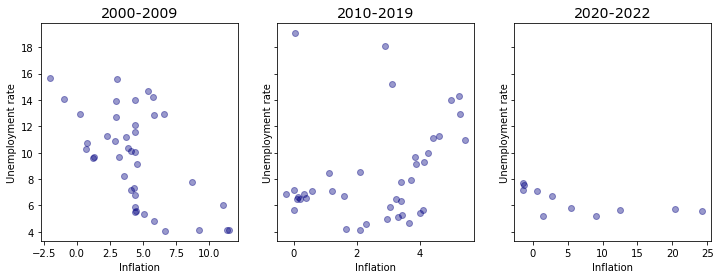

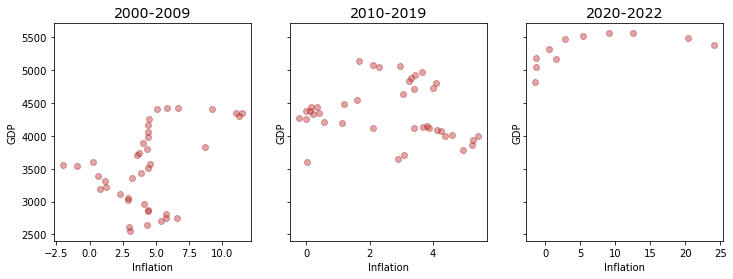

In [12]:
scatter_subs(data=baltic_data_ee, col_1="EE_HICP", col_2="EE_Un", color="navy")
scatter_subs(data=baltic_data_ee, col_1="EE_HICP", col_2="EE_GDP", color="firebrick")

In [13]:
# Testing Causation using Granger’s Causality Test

from statsmodels.tsa.stattools import grangercausalitytests

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(baltic_data_ee, variables = baltic_data_ee.columns)


,EE_GDP_x,EE_HICP_x,EE_Un_x
EE_GDP_y,1.0000,0.0000,0.0367
EE_HICP_y,0.0021,1.0000,0.2373
EE_Un_y,0.0000,0.0003,1.0000


In [14]:
grangers_causation_matrix(baltic_data, variables = baltic_data.columns)

,EE_GDP_x,LV_GDP_x,LT_GDP_x,EE_HICP_x,LV_HICP_x,LT_HICP_x,EE_Un_x,LV_Un_x,LT_Un_x
EE_GDP_y,1.0000,0.0003,0.0037,0.0000,0.0000,0.0000,0.0367,0.0373,0.0628
LV_GDP_y,0.0004,1.0000,0.0331,0.0000,0.0136,0.0013,0.0376,0.0000,0.0142
LT_GDP_y,0.0000,0.0000,1.0000,0.0005,0.0000,0.0004,0.1958,0.0021,0.1183
EE_HICP_y,0.0021,0.0485,0.0169,1.0000,0.0178,0.0000,0.2373,0.0049,0.1950
LV_HICP_y,0.0000,0.0023,0.0125,0.0000,1.0000,0.0132,0.2203,0.0245,0.0418
LT_HICP_y,0.0003,0.0571,0.0042,0.0000,0.0065,1.0000,0.1685,0.0229,0.0114
EE_Un_y,0.0000,0.0000,0.0000,0.0003,0.0000,0.0000,1.0000,0.0000,0.0000
LV_Un_y,0.0000,0.0000,0.0004,0.0000,0.0000,0.0005,0.0002,1.0000,0.0010
LT_Un_y,0.0000,0.0000,0.0052,0.0000,0.0000,0.0001,0.0000,0.0002,1.0000


In [15]:
# Cointegration test

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary
    Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.
    The null hypothesis of the cointegration test is that there is no cointegration among the variables in the VAR model,
    meaning that the linear combination of the variables is not stationary. If the null hypothesis is rejected,
    it suggests that there is cointegration among the variables and that the linear combination of the variables is stationary.
    """
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(baltic_data_ee)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
EE_GDP ::  40.12     > 24.2761   =>   True
EE_HICP ::  10.15     > 12.3212   =>   False
EE_Un  ::  2.43      > 4.1296    =>   False


In [16]:
# Split the Series into Training and Testing Data

nr_obs = 10
data_train,data_test=baltic_data_ee[0:-nr_obs], baltic_data_ee[-nr_obs:]

print(data_train.shape)
print(data_test.shape)

(81, 3)
(10, 3)


/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting me

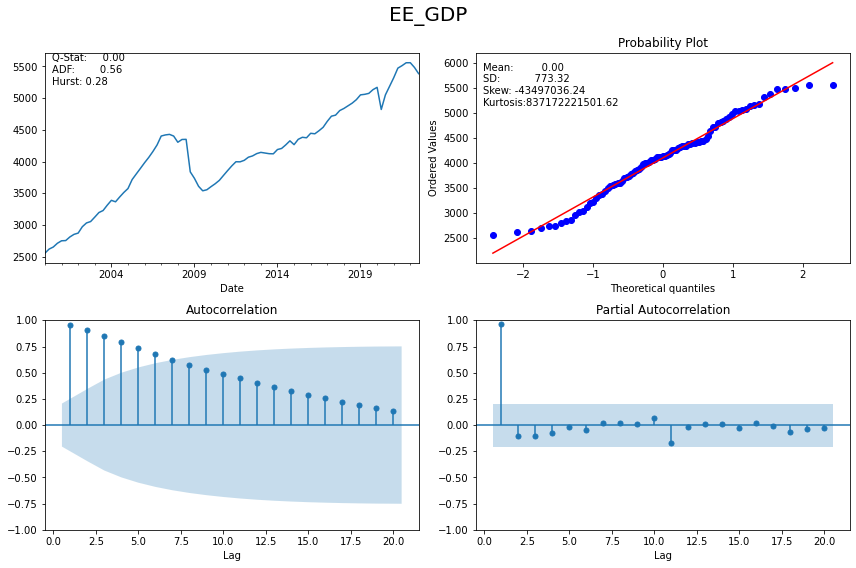

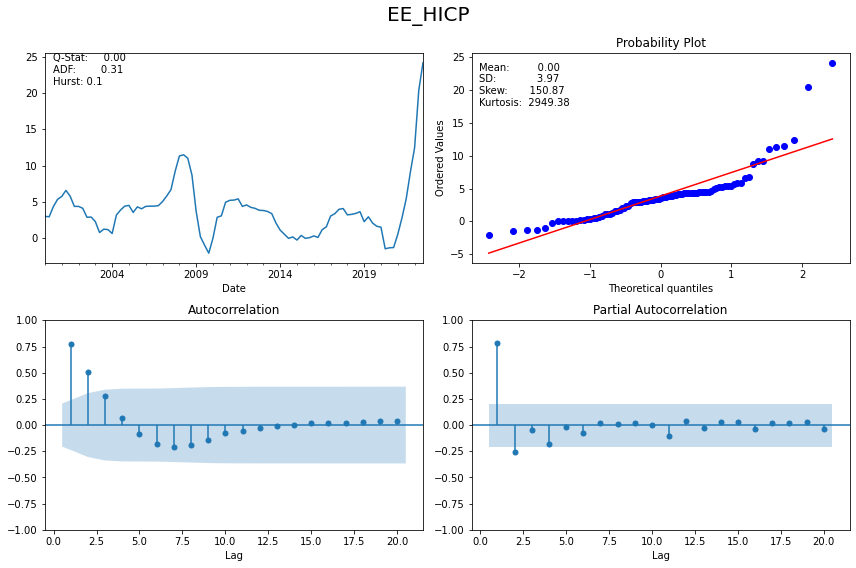

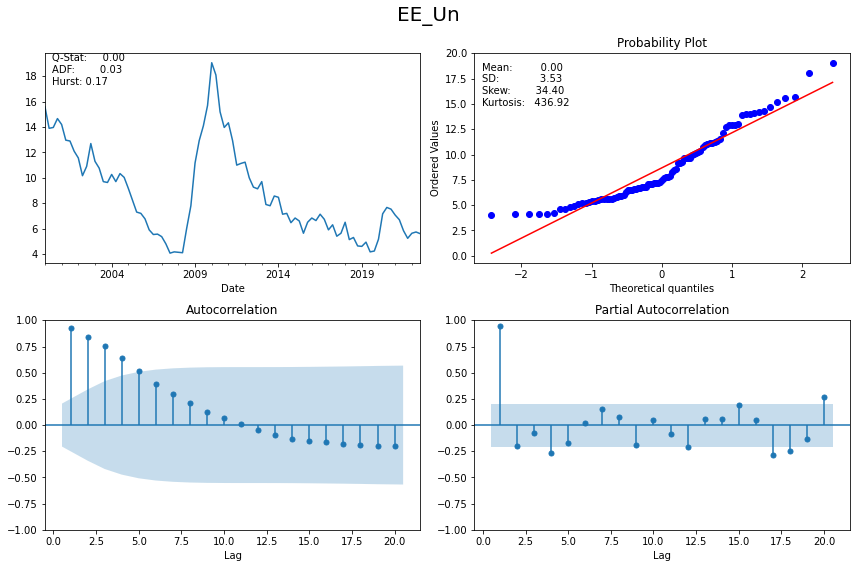

In [17]:
#@title Check for Stationarity and Make the Time Series Stationary
from math import *
import numpy as np

def hurst(ts):
    lags = range(2, 45)
    tau = [sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(np.array(lags)), np.log(tau), 1)
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

for i in baltic_data_ee.columns:
    plot_correlogram(baltic_data_ee[i], lags=20, title=f'{i}')

In [18]:
# Check for Stationarity and Make the Time Series Stationary

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [19]:
for name, column in data_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EE_GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3011
 No. Lags Chosen       = 3
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.6287. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "EE_HICP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0499
 No. Lags Chosen       = 8
 Critical value 1%     = -3.525
 Critical value 5%     = -2.903
 Critical value 10%    = -2.589
 => P-Value = 0.2651. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "EE_Un" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

In [20]:
# The ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.

#1st difference 
data_diff = data_train.diff().dropna()

In [21]:
for name, column in data_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EE_GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7999
 No. Lags Chosen       = 2
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0583. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "EE_HICP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8765
 No. Lags Chosen       = 3
 Critical value 1%     = -3.519
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EE_Un" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Si

In [22]:
#2st difference 
data_diff=data_diff.diff().dropna()

In [23]:
for name, column in data_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EE_GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.1555
 No. Lags Chosen       = 1
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EE_HICP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9616
 No. Lags Chosen       = 11
 Critical value 1%     = -3.532
 Critical value 5%     = -2.906
 Critical value 10%    = -2.59
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EE_Un" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [24]:
# All the series are now stationary.

/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting me

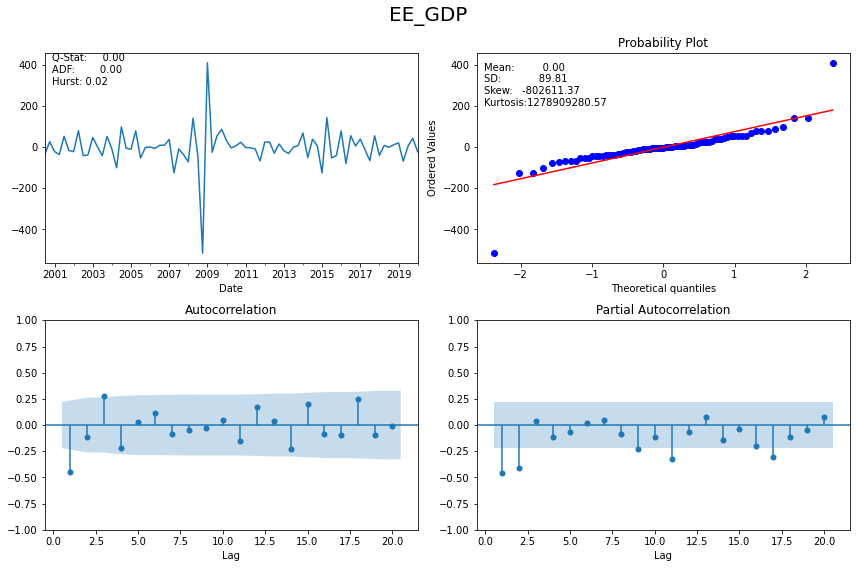

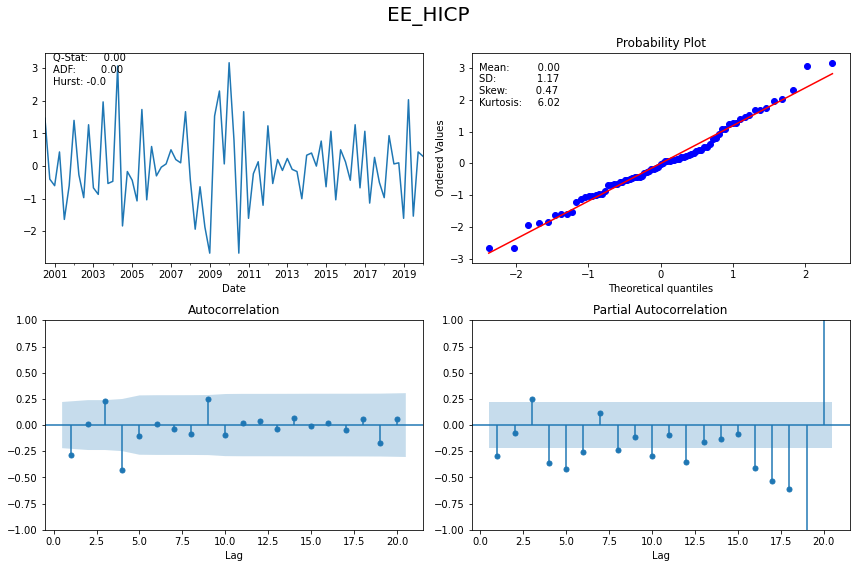

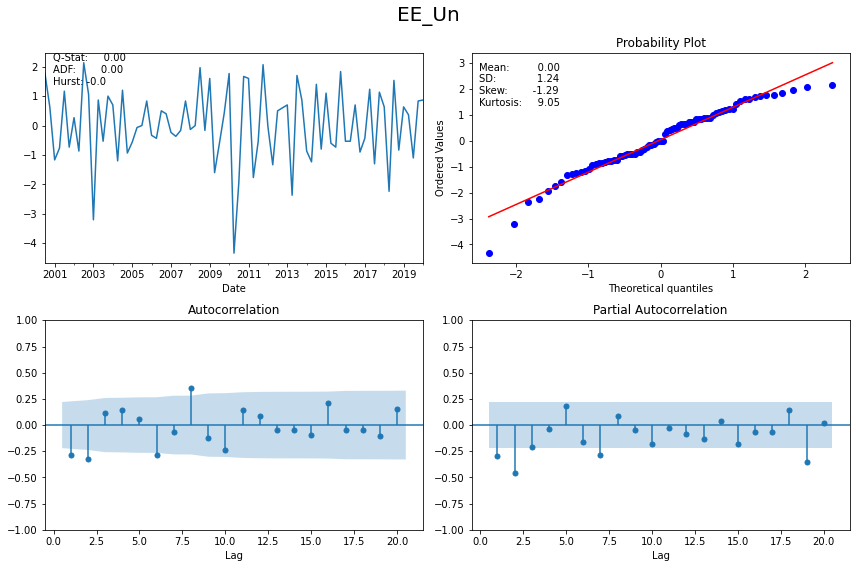

In [25]:
#@title Checking stationarity visually after differencing
for i in data_diff.columns:
    plot_correlogram(data_diff[i], lags=20, title=f'{i}')

In [26]:
def plot_vars(data, levels, color, leveltype):
    
    """
    Displays historical trends of VAR variables
    And see if it's sensible to just select levels instead of differences
    """
    
    fig, ax = plt.subplots(1, 3, figsize=(15,3), sharex=True)
    
    palettes = ["blue", "green", "red", "orange", "purple", "black"]
    
    for col, i in dict(zip(levels, list(range(6)))).items():
        data[col].plot(ax=ax[i], legend=True, linewidth=1.0, color=color, sharex=True)     
    
    fig.set_facecolor("floralwhite")
    fig.suptitle(f"Historical trends of VAR {leveltype} variables", 
                 fontsize=14, fontweight="bold", fontname="Verdana")

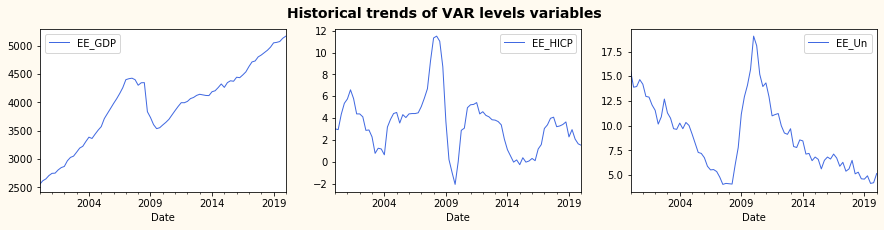

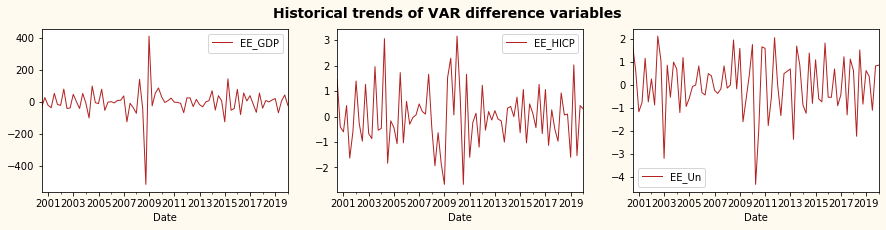

In [27]:
plot_vars(data_train, levels=data_train.columns, color="royalblue", leveltype="levels")
plot_vars(data_diff, levels=data_diff.columns, color="firebrick", leveltype="difference")

In [28]:
# Select the Order (P) of VAR model

forecasting_model = VAR(data_diff)
results_aic = []
for p in range(1,15):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

np.argmin(results_aic)+1

/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


12

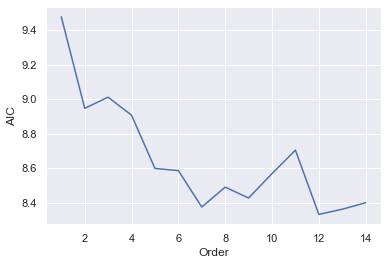

In [29]:
# From visual judgement, it seems should be either 7 or 12

sns.set()
plt.plot(list(np.arange(1,15,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [30]:
# Auto Selection of VAR lag order with built-in function
x=forecasting_model.select_order(maxlags=12)
results_auto = forecasting_model.fit(maxlags = 12, ic = "aic")
lag_order = results_auto.k_ar
lag_order

12

In [31]:
x.summary()

,AIC,BIC,FPE,HQIC
0,9.912,10.01,2.017e+04,9.951
1,9.625,10.02,1.514e+04,9.781
2,9.119,9.810*,9152.,9.393
3,9.188,10.18,9848.,9.579
4,9.012,10.30,8323.,9.520
5,8.639,10.22,5811.,9.264
6,8.639,10.51,5925.,9.381
7,8.397,10.57,4781.*,9.256*
8,8.504,10.97,5527.,9.480
9,8.493,11.26,5745.,9.586


In [32]:
model_fitted = forecasting_model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Jan, 2023
Time:                     21:23:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.9845
Nobs:                     67.0000    HQIC:                   9.77728
Log likelihood:          -453.327    FPE:                    6298.74
AIC:                      8.33196    Det(Omega_mle):         1684.14
--------------------------------------------------------------------
Results for equation EE_GDP
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.143843        10.432920            0.014           0.989
L1.EE_GDP          -0.893703         0.176779           -5.055           0.000
L1.EE_HICP         -3.055765        16.137869           -0.189     

In [34]:
# Durbin-Watson test for serial correlation in residuals

def adjust(val, length= 6):
  return str(val).ljust(length)

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted.resid)

for col, val in zip(baltic_data_ee.columns, out):
    """
    Durbin-Watson:The null hypothesis of the test is that there is no serial correlation in the residuals.
    The Durbin-Watson test statistic is a value between 0 and 4, with values closer to 2 indicating the absence
    of autocorrelation. Regarding our variables, test statistic values are closer to 2, which implies that there is
    no serial correlation among residuals.
    """
    print(adjust(col), ':', round(val, 2))

EE_GDP : 1.97
EE_HICP : 2.27
EE_Un  : 1.82


In [35]:
grangers_causation_matrix(data_diff, variables = data_diff.columns)

,EE_GDP_x,EE_HICP_x,EE_Un_x
EE_GDP_y,1.0000,0.0066,0.0863
EE_HICP_y,0.0001,1.0000,0.0956
EE_Un_y,0.0000,0.0150,1.0000


In [36]:
cointegration_test(data_diff)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
EE_GDP ::  107.9     > 24.2761   =>   True
EE_HICP ::  50.83     > 12.3212   =>   True
EE_Un  ::  14.45     > 4.1296    =>   True


In [37]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 12

# Input data for forecasting
forecast_input = data_diff.values[-lag_order:]
forecast_input

12


array([[-1.26000000e+01, -1.13333333e+00,  1.23333333e+00],
       [-6.48000000e+01,  2.66666667e-01, -1.30000000e+00],
       [ 5.56000000e+01, -5.00000000e-01,  1.13333333e+00],
       [-3.92000000e+01, -9.66666667e-01,  6.33333334e-01],
       [ 9.10000000e+00,  9.33333334e-01, -2.23333333e+00],
       [ 9.09494702e-13,  6.66666660e-02,  1.53333333e+00],
       [ 1.24000000e+01,  1.00000001e-01, -8.33333334e-01],
       [ 2.15000000e+01, -1.60000000e+00,  6.33333334e-01],
       [-6.76000000e+01,  2.03333333e+00,  3.66666666e-01],
       [ 6.50000000e+00, -1.53333333e+00, -1.10000000e+00],
       [ 4.37000000e+01,  4.33333334e-01,  8.33333332e-01],
       [-2.18000000e+01,  2.99999999e-01,  8.66666668e-01]])

In [38]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nr_obs)
df_forecast = pd.DataFrame(fc, index=baltic_data_ee.index[-nr_obs:], columns=baltic_data_ee.columns + '_2d')
df_forecast

,EE_GDP_2d,EE_HICP_2d,EE_Un_2d
Date,,,
2020-04-01,52.148052,-0.922470,-1.983825
2020-07-01,-43.126228,1.546538,0.203307
2020-10-01,-29.566169,-0.002423,1.323523
2021-01-01,101.024871,-0.180319,-1.844509
2021-04-01,-60.379494,-0.744127,1.469183
2021-07-01,-61.829988,0.998892,-0.644288
2021-10-01,66.879408,-1.766605,-0.111207
2022-01-01,-17.482699,0.879030,1.295144
2022-04-01,-11.883472,-0.321746,-1.798031


In [39]:
# Invert the transformation to get the real forecast

def invert_transformation(data_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = data_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (data_train[col].iloc[-1]-data_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = data_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [40]:
df_results = invert_transformation(data_train, df_forecast, second_diff=True)        
df_results.loc[:, ['EE_GDP_forecast', 'EE_HICP_forecast', 'EE_Un_forecast']]

,EE_GDP_forecast,EE_HICP_forecast,EE_Un_forecast
Date,,,
2020-04-01,5259.448052,0.477530,4.116175
2020-07-01,5305.269876,0.968265,3.268991
2020-10-01,5321.525532,1.456576,3.745330
2021-01-01,5438.806058,1.764569,2.377159
2021-04-01,5495.707091,1.328436,2.478171
2021-07-01,5490.778136,1.891194,1.934895
2021-10-01,5552.728589,0.687347,1.280412
2022-01-01,5597.196342,0.362531,1.921073
2022-04-01,5629.780624,-0.284031,0.763704


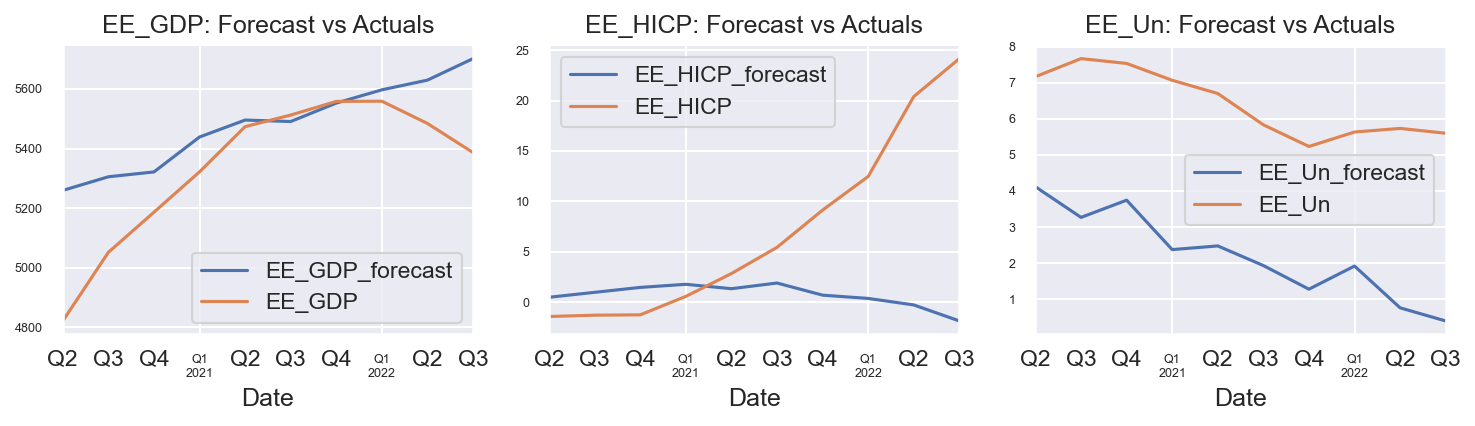

In [41]:
# Plot of Forecast vs Actuals

fig, axes = plt.subplots(nrows=int(len(baltic_data_ee.columns)/2), ncols=3, dpi=150, figsize=(10,3))
for i, (col,ax) in enumerate(zip(baltic_data_ee.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data_test[col][-nr_obs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

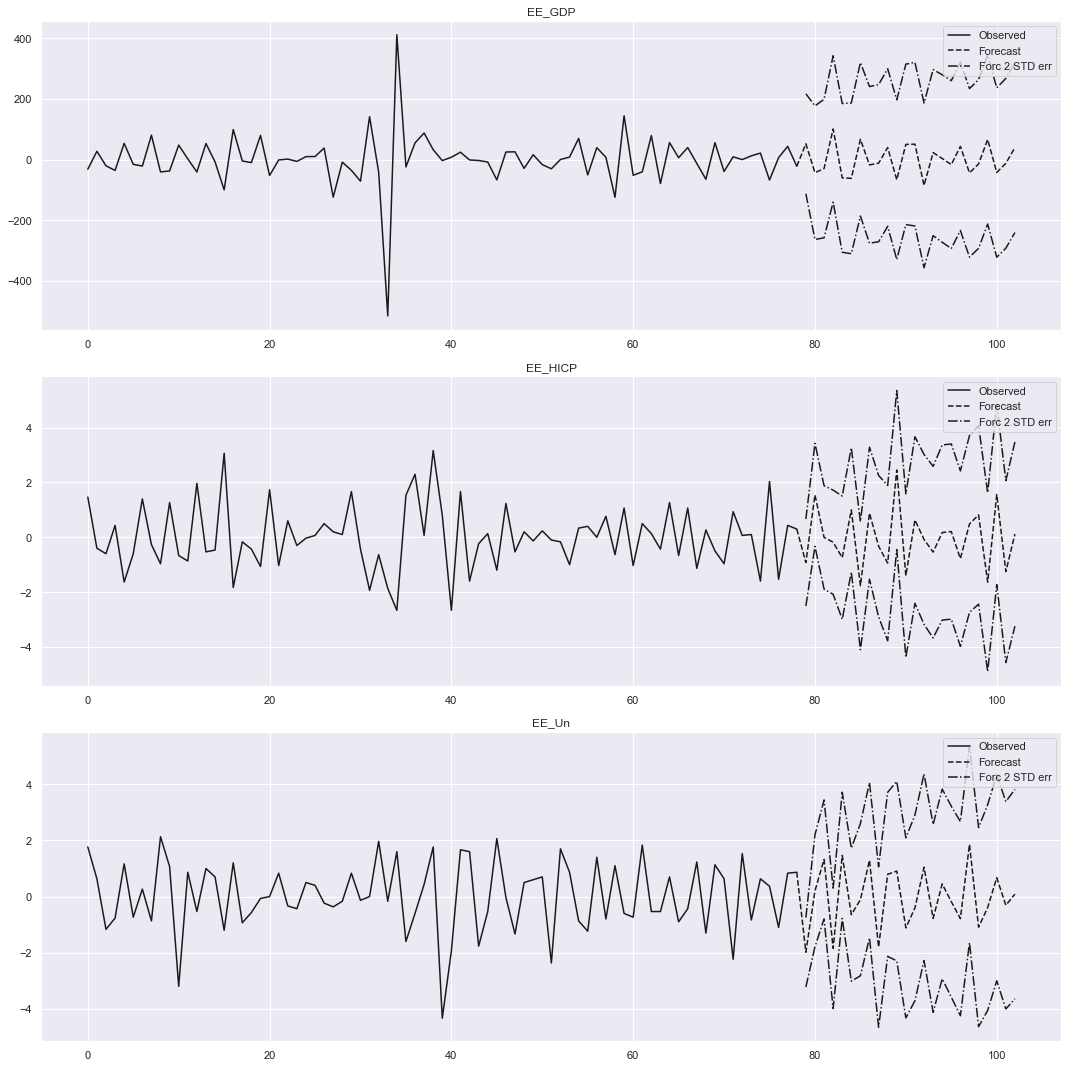

In [42]:
# Plot forecasting
plt=model_fitted.plot_forecast(24)
plt.set_size_inches(15, 15)
plt.tight_layout()

In [43]:
# Evaluate the Forecasts

from statsmodels.tsa.stattools import acf

def adjust(val, length= 6):
  return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: EE_HICP')
accuracy_prod = forecast_accuracy(df_results['EE_HICP_forecast'].values, data_test['EE_HICP'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: EE_Un')
accuracy_prod = forecast_accuracy(df_results['EE_Un_forecast'].values, data_test['EE_Un'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: EE_GDP')
accuracy_prod = forecast_accuracy(df_results['EE_GDP_forecast'].values, data_test['EE_GDP'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))



Forecast Accuracy of: EE_HICP
mape   :  1.2512
me     :  -6.4222
mae    :  8.0422
mpe    :  -0.8284
rmse   :  11.6459
corr   :  -0.8213
minmax :  1.4063

Forecast Accuracy of: EE_Un
mape   :  0.6674
me     :  -4.1881
mae    :  4.1881
mpe    :  -0.6674
rmse   :  4.2326
corr   :  0.86
minmax :  0.6674

Forecast Accuracy of: EE_GDP
mape   :  0.029
me     :  143.8022
mae    :  149.2608
mpe    :  0.028
rmse   :  202.8464
corr   :  0.8178
minmax :  0.0275


/var/folders/_k/jkhn9b4n2dd85wvqhy8ty7bh0000gp/T/ipykernel_31129/4194183322.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
/var/folders/_k/jkhn9b4n2dd85wvqhy8ty7bh0000gp/T/ipykernel_31129/4194183322.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


## Train on EE data and check for LT and LV

In [44]:
#1st difference 
data_diff2 = baltic_data_ee.diff().dropna()
#2d difference 
data_diff2 = data_diff2.diff().dropna()

for name, column in data_diff2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EE_GDP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.6701
 No. Lags Chosen       = 1
 Critical value 1%     = -3.508
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EE_HICP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6319
 No. Lags Chosen       = 11
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0052. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EE_Un" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [45]:
grangers_causation_matrix(data_diff2, variables = data_diff2.columns)

,EE_GDP_x,EE_HICP_x,EE_Un_x
EE_GDP_y,1.0000,0.0050,0.1206
EE_HICP_y,0.0017,1.0000,0.2578
EE_Un_y,0.0000,0.0285,1.0000


In [46]:
cointegration_test(data_diff2)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
EE_GDP ::  97.63     > 24.2761   =>   True
EE_HICP ::  41.9      > 12.3212   =>   True
EE_Un  ::  11.79     > 4.1296    =>   True


In [47]:
forecasting_model2 = VAR(data_diff2)

results_auto2 = forecasting_model2.fit(maxlags = 12, ic = "aic")
lag_order2 = results_auto2.k_ar
lag_order2

/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


8

In [48]:
model_fitted2 = forecasting_model2.fit(lag_order2)
model_fitted2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Jan, 2023
Time:                     21:25:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.4739
Nobs:                     81.0000    HQIC:                   10.1463
Log likelihood:          -644.701    FPE:                    11149.9
AIC:                      9.25678    Det(Omega_mle):         4975.18
--------------------------------------------------------------------
Results for equation EE_GDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -2.549464        10.795041           -0.236           0.813
L1.EE_GDP         -0.785766         0.145737           -5.392           0.000
L1.EE_HICP         0.121757        12.119509            0.010          

In [49]:
# Durbin-Watson test for serial correlation in residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(model_fitted2.resid)

for col, val in zip(baltic_data_ee.columns, out):
    """
    Durbin-Watson:The null hypothesis of the test is that there is no serial correlation in the residuals.
    The Durbin-Watson test statistic is a value between 0 and 4, with values closer to 2 indicating the absence
    of autocorrelation. Regarding our variables, test statistic values are closer to 2, which implies that there is
    no serial correlation among residuals.
    """
    print(adjust(col), ':', round(val, 2))

EE_GDP : 2.03
EE_HICP : 2.01
EE_Un  : 1.95


In [50]:
nr_obs2 = 20

In [51]:
baltic_data_lv = baltic_data.filter(regex='^LV',axis=1)
baltic_data_lt = baltic_data.filter(regex='^LT',axis=1)

In [52]:
data_train_lv, data_test_lv = baltic_data_lv[0:-nr_obs2], baltic_data_lv[-nr_obs2:]
data_diff_lv = data_train_lv.diff().dropna()
data_diff_lv=data_diff_lv.diff().dropna()

data_train_lt, data_test_lt = baltic_data_lt[0:-nr_obs2], baltic_data_lt[-nr_obs2:]
data_diff_lt = data_train_lt.diff().dropna()
data_diff_lt=data_diff_lt.diff().dropna()

In [53]:
# Input data for forecasting LV and LT
forecast_input_lv = data_diff_lv.values[-lag_order2:]
forecast_input_lv

forecast_input_lt = data_diff_lt.values[-lag_order2:]
forecast_input_lt

array([[-27.6       ,   0.7       ,   1.56666667],
       [  6.8       ,   0.73333333,  -0.96666667],
       [ 26.8       ,  -1.23333333,   0.13333333],
       [ 28.1       ,   0.1       ,  -0.16666667],
       [ 15.1       ,   1.        ,   0.63333333],
       [ -0.5       ,   0.8       ,   0.26666667],
       [-19.6       ,  -1.26666667,  -1.43333333],
       [  7.6       ,   0.6       ,   0.6       ]])

In [54]:
# Forecast
fc_lv = model_fitted2.forecast(y=forecast_input_lv, steps=nr_obs2)
df_forecast_lv = pd.DataFrame(fc_lv, index=baltic_data_lv.index[-nr_obs2:], columns=baltic_data_lv.columns + '_2d')
df_forecast_lv

fc_lt = model_fitted2.forecast(y=forecast_input_lt, steps=nr_obs2)
df_forecast_lt = pd.DataFrame(fc_lt, index=baltic_data_lt.index[-nr_obs2:], columns=baltic_data_lt.columns + '_2d')
df_forecast_lt

,LT_GDP_2d,LT_HICP_2d,LT_Un_2d
Date,,,
2017-10-01,-37.762933,0.297338,0.022688
2018-01-01,15.052157,-0.905144,-0.056239
2018-04-01,91.387765,1.286784,0.171401
2018-07-01,-142.684271,-0.245914,-0.054021
2018-10-01,22.014174,-0.746602,0.427723
2019-01-01,28.780213,-0.068685,0.267435
2019-04-01,-65.535479,-0.037801,-0.610405
2019-07-01,70.047866,-0.230888,0.058216
2019-10-01,-2.870483,0.288685,0.702759


In [55]:
# Invert the transformation to get the real forecast

df_results_lv = invert_transformation(baltic_data_lv, df_forecast_lv, second_diff=True)        
df_results_lv.loc[:, ['LV_GDP_forecast', 'LV_HICP_forecast', 'LV_Un_forecast']]

df_results_lt = invert_transformation(baltic_data_lt, df_forecast_lt, second_diff=True)        
df_results_lt.loc[:, ['LT_GDP_forecast', 'LT_HICP_forecast', 'LT_Un_forecast']]

,LT_GDP_forecast,LT_HICP_forecast,LT_Un_forecast
Date,,,
2017-10-01,10743.037067,24.764005,6.222688
2018-01-01,10774.826291,27.122866,6.655804
2018-04-01,10898.003280,30.768511,7.260321
2018-07-01,10878.495998,34.168242,7.810817
2018-10-01,10881.002891,36.821371,8.789036
2019-01-01,10912.289996,39.405815,10.034690
2019-04-01,10878.041623,41.952458,10.669938
2019-07-01,10913.841115,44.268212,11.363402
2019-10-01,10946.770125,46.872651,12.759625


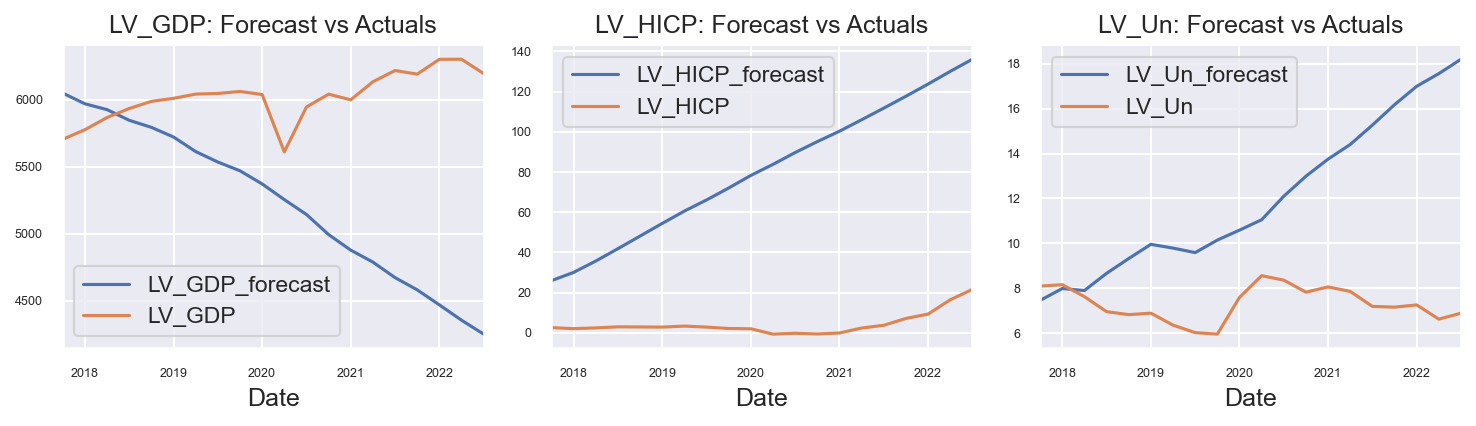

In [57]:
# Plot of Forecast vs Actuals

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=int(len(baltic_data_lv.columns)/2), ncols=3, dpi=150, figsize=(10,3))
for i, (col,ax) in enumerate(zip(baltic_data_lv.columns, axes.flatten())):
    df_results_lv[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data_test_lv[col][-nr_obs2:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

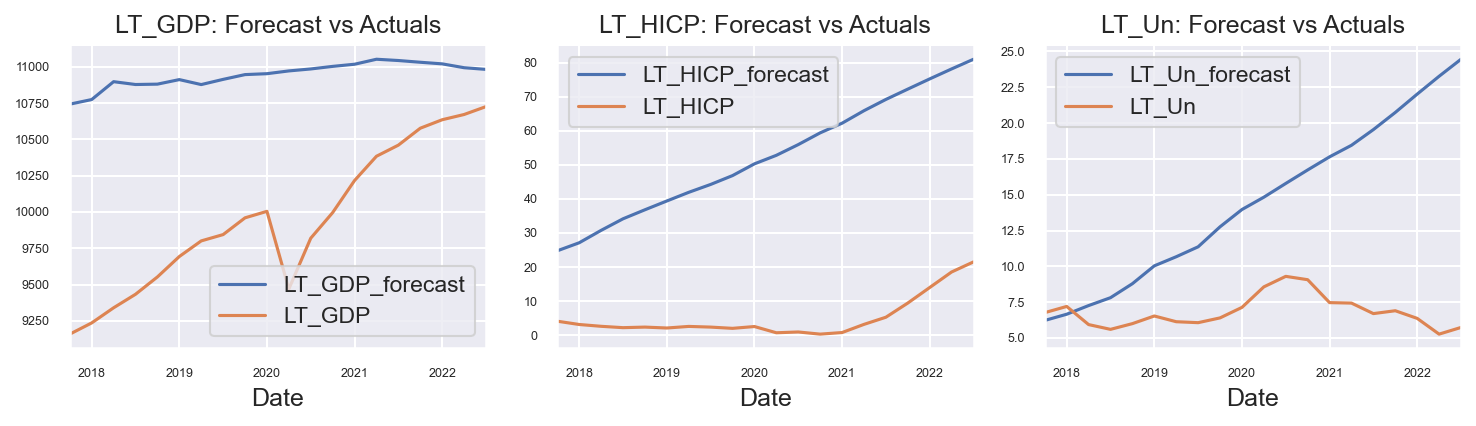

In [58]:
fig, axes = plt.subplots(nrows=int(len(baltic_data_lt.columns)/2), ncols=3, dpi=150, figsize=(10,3))
for i, (col,ax) in enumerate(zip(baltic_data_lt.columns, axes.flatten())):
    df_results_lt[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data_test_lt[col][-nr_obs2:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [68]:
# EE
forecast_input_ee = data_diff2.values[-lag_order2:]

fc_ee2 = model_fitted2.forecast(y=forecast_input_ee, steps=nr_obs2)
df_forecast_ee = pd.DataFrame(fc_ee2, index=baltic_data_ee.index[-nr_obs2:], columns=baltic_data_ee.columns + '_2d')

In [69]:
df_results_ee = invert_transformation(baltic_data_ee, df_forecast_ee, second_diff=True)        
# df_results_ee.loc[:, ['EE_GDP_forecast', 'EE_HICP_forecast', 'EE_Un_forecast']]

In [70]:
data_train2,data_test2=baltic_data_ee[0:-nr_obs2], baltic_data_ee[-nr_obs2:]

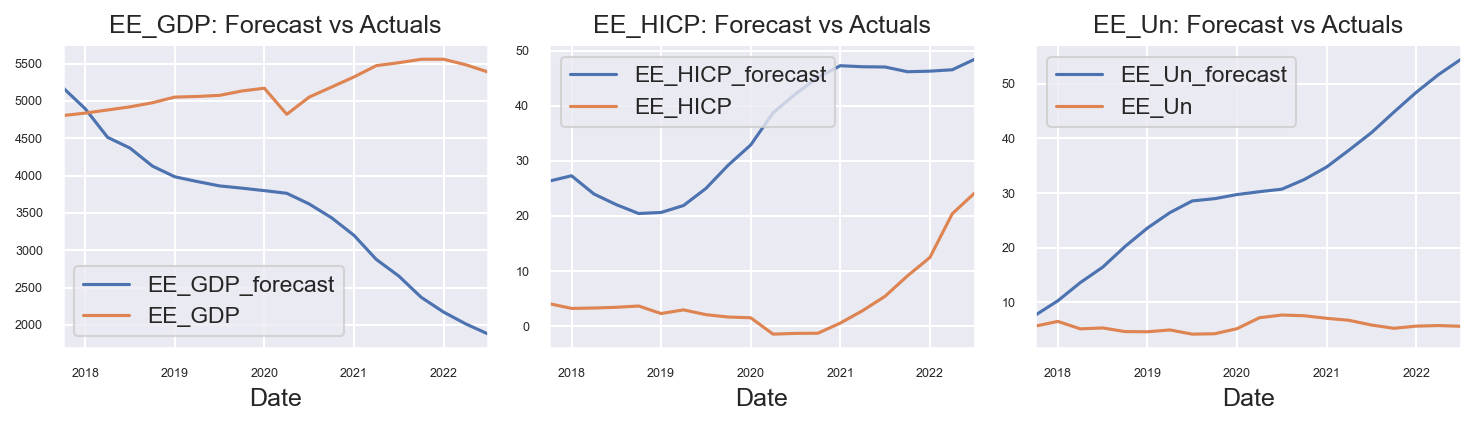

In [71]:
fig, axes = plt.subplots(nrows=int(len(baltic_data_ee.columns)/2), ncols=3, dpi=150, figsize=(10,3))
for i, (col,ax) in enumerate(zip(baltic_data_ee.columns, axes.flatten())):
    df_results_ee[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data_test2[col][-nr_obs2:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

## Without differentiation EE

In [108]:
nr_obs3 = 10

In [109]:
data_train3,data_test3=baltic_data_ee[0:-nr_obs3], baltic_data_ee[-nr_obs3:]

In [110]:
forecasting_model3 = VAR(data_train3)

results_auto3 = forecasting_model3.fit(maxlags = 12, ic = "aic")
lag_order3 = results_auto3.k_ar
lag_order3

/Users/aleksandragrishechko/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


9

In [111]:
model_fitted3 = forecasting_model3.fit(lag_order3)
model_fitted3.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, Jan, 2023
Time:                     21:36:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.4379
Nobs:                     72.0000    HQIC:                   8.83918
Log likelihood:          -502.635    FPE:                    2728.16
AIC:                      7.78177    Det(Omega_mle):         1018.28
--------------------------------------------------------------------
Results for equation EE_GDP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const            -17.338087       185.980175           -0.093           0.926
L1.EE_GDP          0.852657         0.152232            5.601           0.000
L1.EE_HICP       -11.529277        13.182218           -0.875          

In [112]:
forecast_input_ee3 = data_train3.values[-lag_order3:]

fc_ee3 = model_fitted3.forecast(y=forecast_input_ee3, steps=nr_obs3)
df_forecast_ee3 = pd.DataFrame(fc_ee3, index=baltic_data_ee.index[-nr_obs3:], columns=baltic_data_ee.columns + '_2d')

In [113]:
df_results_ee3 = invert_transformation(baltic_data_ee, df_forecast_ee3, second_diff=True)        
# df_results_ee.loc[:, ['EE_GDP_forecast', 'EE_HICP_forecast', 'EE_Un_forecast']]

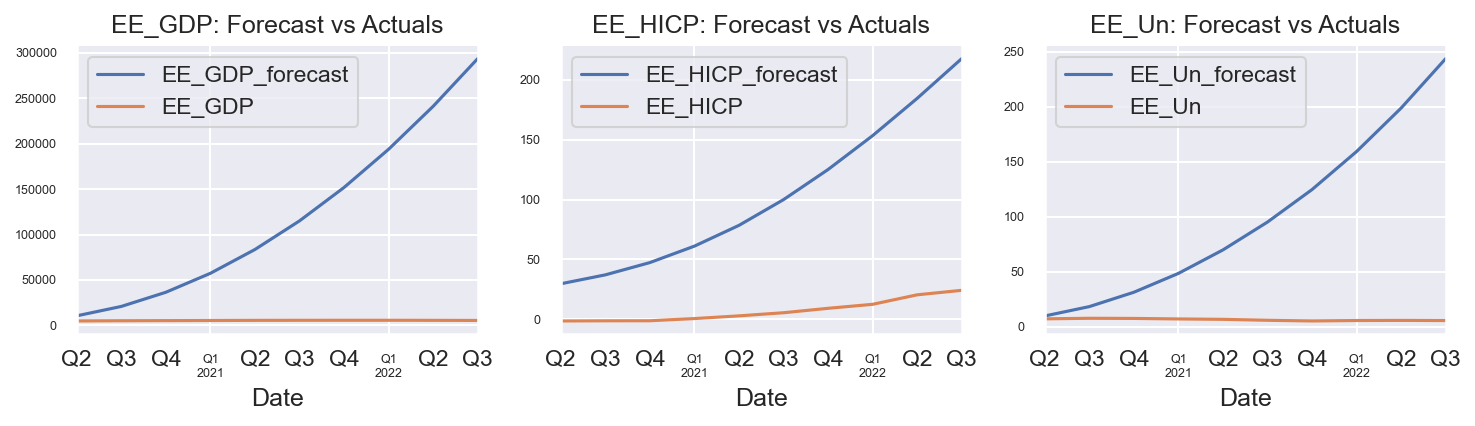

In [114]:
fig, axes = plt.subplots(nrows=int(len(baltic_data_ee.columns)/2), ncols=3, dpi=150, figsize=(10,3))
for i, (col,ax) in enumerate(zip(baltic_data_ee.columns, axes.flatten())):
    df_results_ee3[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    data_test3[col][-nr_obs2:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()